In [1]:
import numpy as np
import pandas as pd
import glob
import os
from importlib import reload

In [2]:
from sklearn.neighbors import KernelDensity
import geopandas
import cartopy.io.img_tiles as cimgt

import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy import config
from shapely.geometry import Point
from shapely.prepared import prep
import cartopy

import shapely.geometry as sgeom
from scipy.io import netcdf

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
warnings.filterwarnings("ignore", module = "matplotlib\..*" )

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors

In [3]:
popdata = pd.read_csv('../data/worldcities.csv')

popdata = popdata[popdata.population > 1e4]
#popdata.population /= 1e4

print(popdata.shape)
popdata.head(5)

(28260, 11)


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6839,139.7744,Japan,JP,JPN,Tōkyō,primary,39105000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,35362000.0,1360771077
2,Delhi,Delhi,28.6667,77.2167,India,IN,IND,Delhi,admin,31870000.0,1356872604
3,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,23971000.0,1608618140
4,São Paulo,Sao Paulo,-23.5504,-46.6339,Brazil,BR,BRA,São Paulo,admin,22495000.0,1076532519


In [4]:
# request data for use by geopandas
resolution = '10m'
category = 'cultural'
#name = 'admin_1_states_provinces_lines'
name = 'admin_0_countries'

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

shpfilename = shpreader.natural_earth(resolution, category, name)
df = geopandas.read_file(shpfilename)
ll_proj = ccrs.PlateCarree()  #CRS for raw long/lat
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m')

In [5]:
src = '../results/'
dst = '../plots/'
R = 6371000/1000
R = 1

#filename = src + 'uqlocations.tsv'
#data = pd.read_table(filename, header=None)
#data.columns = ['incountry_rank', 'country', 'location', 'score', 'latitude', 'longitude']

filename = src + 'merged_locations.csv'
data = pd.read_csv(filename)

print(data.shape)
countries = pd.unique(data.country)

#data.head()

(7972, 6)


In [6]:
kdx = 8
dfcountry = data[data['country'] == countries[kdx]]
#dfcountry = data

rlatlon = dfcountry.iloc[:, 4:].values
rlatlonr = rlatlon*np.pi / 180.0  # Convert lat/long to radians

print(dfcountry.shape)
dfcountry.head()

(28, 6)


,incountry_rank,country,location,score,latitude,longitude
360,0,Austria,"Vienna, Austria",2529,48.208174,16.373819
361,1,Austria,"Innsbruck, Austria",555,47.269212,11.404102
362,2,Austria,"Graz, Austria",405,47.070714,15.439504
363,3,Austria,"Tulln, Austria",251,48.331495,16.060737
364,4,Austria,"Salzburg, Austria",206,47.809490,13.055010


In [7]:
pad1 = .1  #padding, degrees unit

poly = [df.loc[df['ADMIN'] == countries[kdx]]['geometry'].values[0]]
#poly = [df.loc[df['ADMIN'] == 'United States of America']['geometry'].values[0]]

exts = [poly[0].bounds[0] - pad1, poly[0].bounds[2] + pad1, poly[0].bounds[1] - pad1, poly[0].bounds[3] + pad1];
#exts[1] = -65; exts[2]= 18
#exts[2] = -35
rmask = (rlatlon[:, 0] > exts[2]) & (rlatlon[:, 0] < exts[3]) & (rlatlon[:,1] > exts[0]) & (rlatlon[:,1] < exts[1])

rscore = dfcountry['score'].values.copy()
rscore = rscore[rmask]

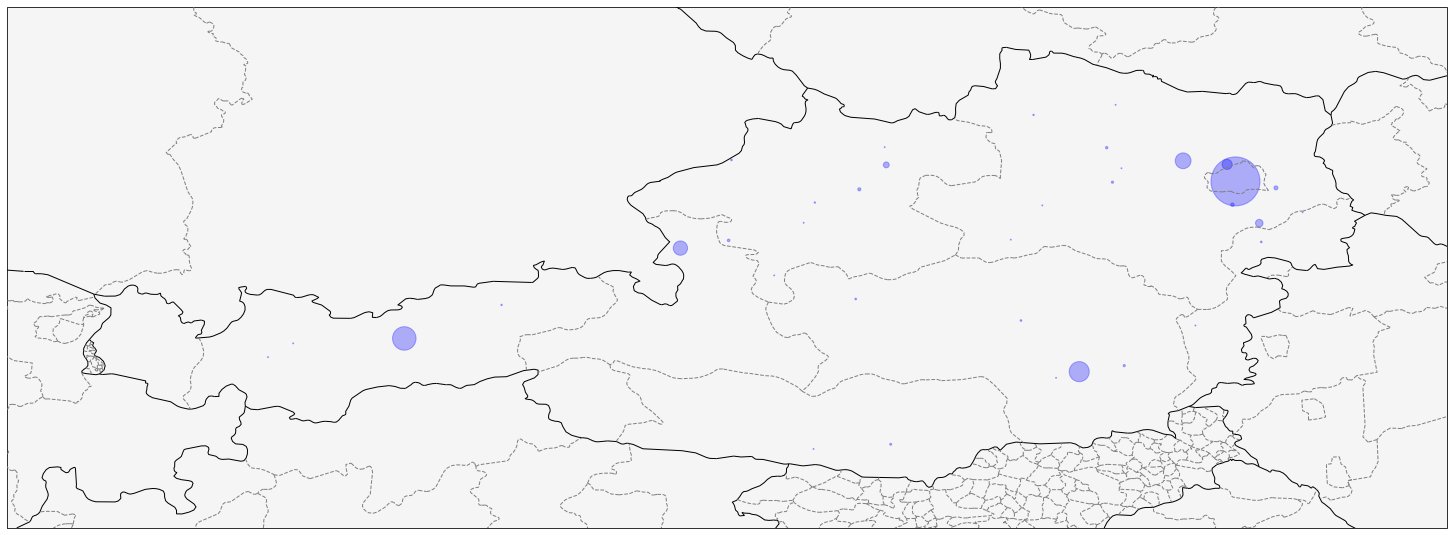

In [100]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
#score[score > 1000] = 1000

ax.add_feature(land_10m, zorder=0, edgecolor='black', facecolor='whitesmoke')
ax.scatter(dfcountry.longitude[rmask], dfcountry.latitude[rmask], transform=ccrs.PlateCarree(), 
           s=rscore, marker='o', alpha=0.3, zorder=2, color='blue');
ax.scatter(exts[:2], exts[2:], transform=ccrs.PlateCarree(), facecolor='whitesmoke')

ax.add_feature(cfeature.BORDERS, zorder=19, edgecolor='black', linestyle='-');
ax.add_feature(states_provinces, edgecolor='gray', linestyle='--', zorder=20);

#ax.set_title('Globe publication frequencies [all authors]', fontsize=30)
#filename = dst + 'frequencies_globe'
#plt.savefig(filename + '.jpg', dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

In [101]:
resol = 0.1
lons = np.arange(exts[0], exts[1], resol)
lats = np.arange(exts[2], exts[3], resol)
lon_grid, lat_grid = np.meshgrid(lons, lats)

points = [Point(point) for point in zip(lon_grid.ravel(), lat_grid.ravel())]


land_polygon = prep(poly[0])

land = []
land.extend([tuple(point.coords)[0] for point in filter(land_polygon.covers, points)])
land = np.asarray(land)

xy = np.pi*land/180.0
xy = xy[:, [1,0]]
xs, ys = land.T
print(xy.shape)

(1009, 2)


In [102]:
if 1 == 0:

    loncounts = np.zeros(len(lons), dtype=int)
    latcounts = np.zeros(len(lats), dtype=int)
    for i in range(len(loncounts)):
        loncounts[i] = np.sum(land[:, 0] == lons[i])
    for i in range(len(latcounts)):
        latcounts[i] = np.sum(land[:, 1] == lats[i])
    print(np.sum(loncounts), np.sum(latcounts), land.shape, sep='\t')

In [103]:
R = 1
rads = np.deg2rad(resol)
srads = np.sin(rads)
areas = rads*R*R*np.abs(np.cos(xy[:,0])*srads)#+rads*0.5) - np.sin(xy[:,0]-rads*0.5))
A = np.sum(areas)
print(A)
print('Normalizing radius:', np.sqrt(1./A))
print('Real surface area:', np.round(A*6371**2,2),'km^2')

0.0020729987252437756
Normalizing radius: 21.963446092788615
Real surface area: 84142.27 km^2


In [104]:
if 1 == 0:
    R = np.sqrt(1./A)
    rads = np.deg2rad(resol)
    srads = np.sin(rads)
    areas = rads*R*R*np.abs(np.cos(xy[:,0])*srads)#+rads*0.5) - np.sin(xy[:,0]-rads*0.5))
    A = np.sum(areas)
    print(A)

In [105]:
bw = 0.04
kde_params = {'bandwidth': bw, 'metric':'haversine', 'kernel':'linear', 'algorithm':'ball_tree'}

rkde = KernelDensity(**kde_params)
rkde.fit(rlatlonr[rmask,:], sample_weight=rscore)

rlhood = np.exp(rkde.score_samples(xy))
rout = rlhood/np.sum(rlhood*areas)
Rout = areas*np.sum(rscore)*rout
print(np.max(rlhood), np.max(rout))
len(rout)

433.8085343325425 1047.8693008966125


1009

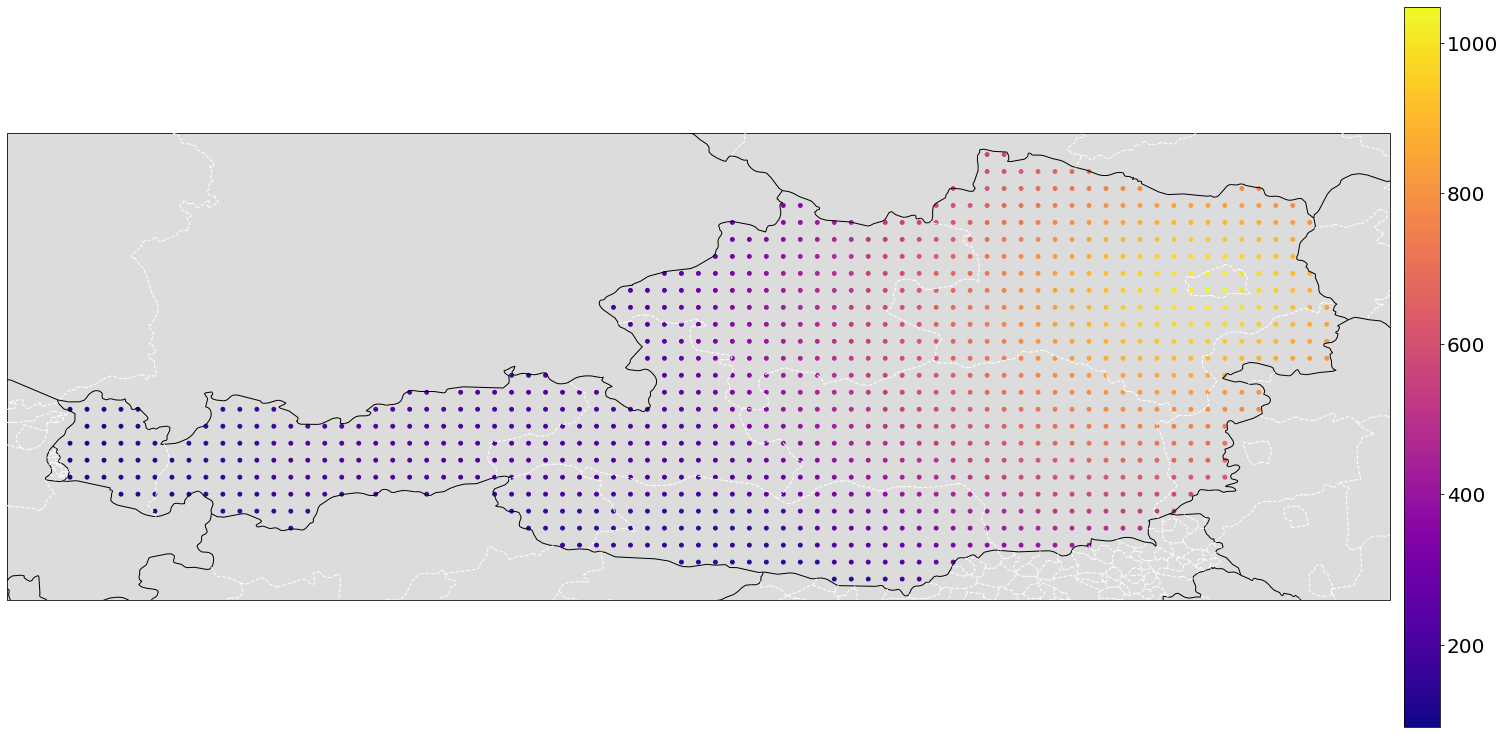

In [106]:
fs, pad, frac, s = 20, 0.01, 0.03, 10
fig = plt.figure(figsize=(20, 10))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.set_facecolor('lightsteelblue')
ax.add_feature(land_10m, zorder=0, edgecolor='black', facecolor='gainsboro')

cs = ax.scatter(xs, ys, transform=ccrs.PlateCarree(), s=15, marker='o', c=rout, alpha=1, zorder=2, cmap='plasma');
#ax.scatter(rlatlon[rmask, 1], rlatlon[rmask, 0], transform=ccrs.PlateCarree(), 
#           s=1, marker='.', alpha=0.25, zorder=3, color='lime');

ax.add_feature(cfeature.BORDERS, zorder=19, edgecolor='black', linestyle='-');
ax.add_feature(states_provinces, edgecolor='white', linestyle='--', zorder=20);

cbar = fig.colorbar(cs, fraction=frac, pad=pad, ax=ax)
cbar.ax.tick_params(labelsize=fs);

In [107]:
signif = 0.95
vols = rout*areas
argsort = np.argsort(vols)[::-1]
foo = np.sum(np.cumsum(vols[argsort]) < signif)
smask = argsort[:foo]

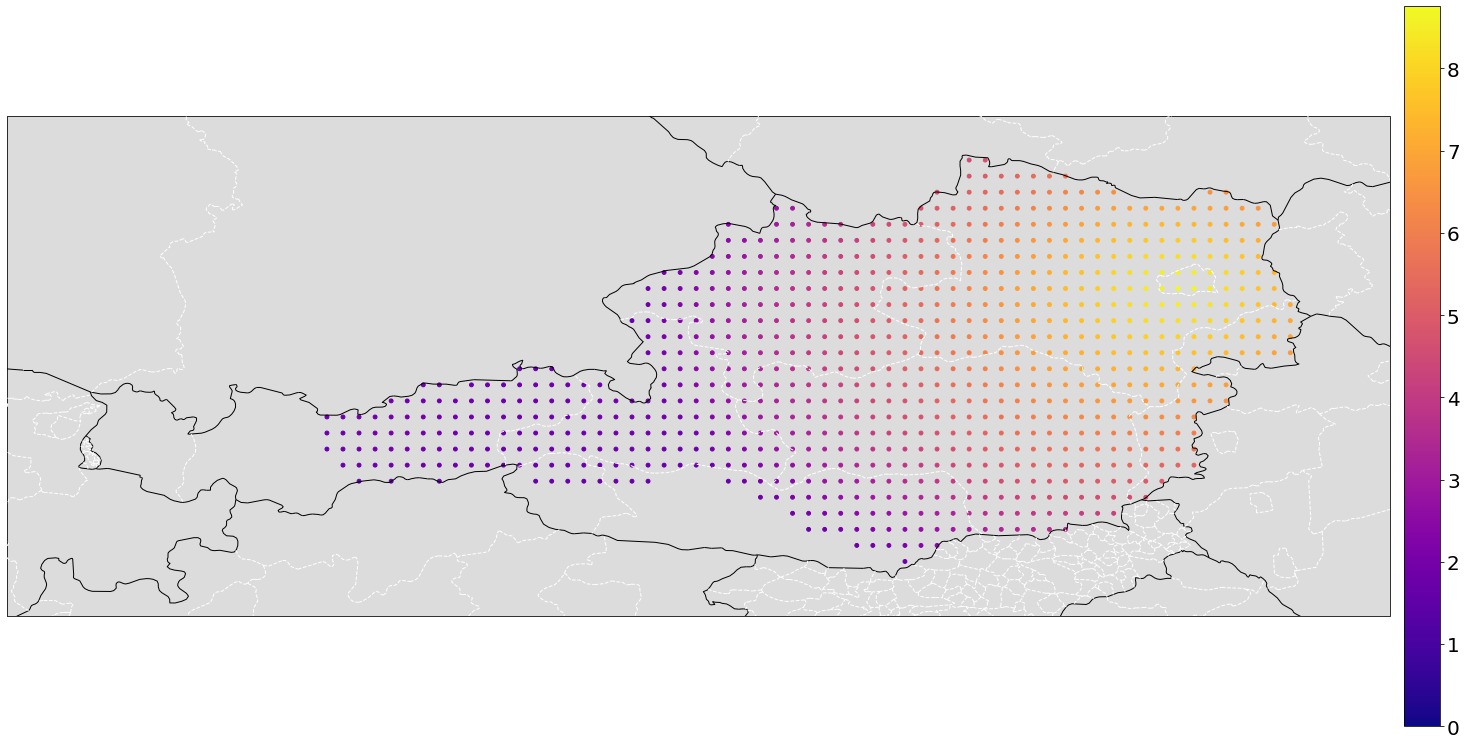

In [108]:
#divnorm=colors.TwoSlopeNorm(v)

fs, pad, frac, s = 20, 0.01, 0.03, 10
fig = plt.figure(figsize=(20, 10))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.set_facecolor('lightsteelblue')
ax.add_feature(land_10m, zorder=0, edgecolor='black', facecolor='gainsboro')

cs = ax.scatter(xs[smask], ys[smask], transform=ccrs.PlateCarree(), vmin=0,
                s=15, marker='o', c=Rout[smask], alpha=1, zorder=2, cmap='plasma');
ax.scatter(exts[:2], exts[2:], transform=ccrs.PlateCarree(), facecolor='whitesmoke', alpha=0);

ax.add_feature(cfeature.BORDERS, zorder=19, edgecolor='black', linestyle='-');
ax.add_feature(states_provinces, edgecolor='white', linestyle='--', zorder=20);

cbar = fig.colorbar(cs, fraction=frac, pad=pad, ax=ax)
cbar.ax.tick_params(labelsize=fs);

In [109]:
np.sort(df['ADMIN'])

array(['Afghanistan', 'Akrotiri Sovereign Base Area', 'Aland', 'Albania',
       'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Anguilla',
       'Antarctica', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Aruba', 'Ashmore and Cartier Islands', 'Australia', 'Austria',
       'Azerbaijan', 'Bahrain', 'Bajo Nuevo Bank (Petrel Is.)',
       'Bangladesh', 'Barbados', 'Baykonur Cosmodrome', 'Belarus',
       'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bir Tawil',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brazilian Island', 'British Indian Ocean Territory',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Clipperton Island', 'Colombia', 'Comoros',
       'Cook Islands', 'Coral Sea Islands', 'Costa Rica', 'Croatia',
       'Cuba', 'Curaçao', 'Cyprus', 'Cyprus No Mans A

## Population density

In [110]:
cpop = popdata[popdata.country == countries[kdx]]
#cpop = popdata[popdata.country == 'United States']
#cpop.population 

pmask = (cpop.lat > exts[2]) & (cpop.lat < exts[3]) & (cpop.lng > exts[0]) & (cpop.lng < exts[1])

pscore = cpop.population.values.copy()
pscore = pscore[pmask]
pscore = np.sum(rscore)*pscore/np.sum(pscore)

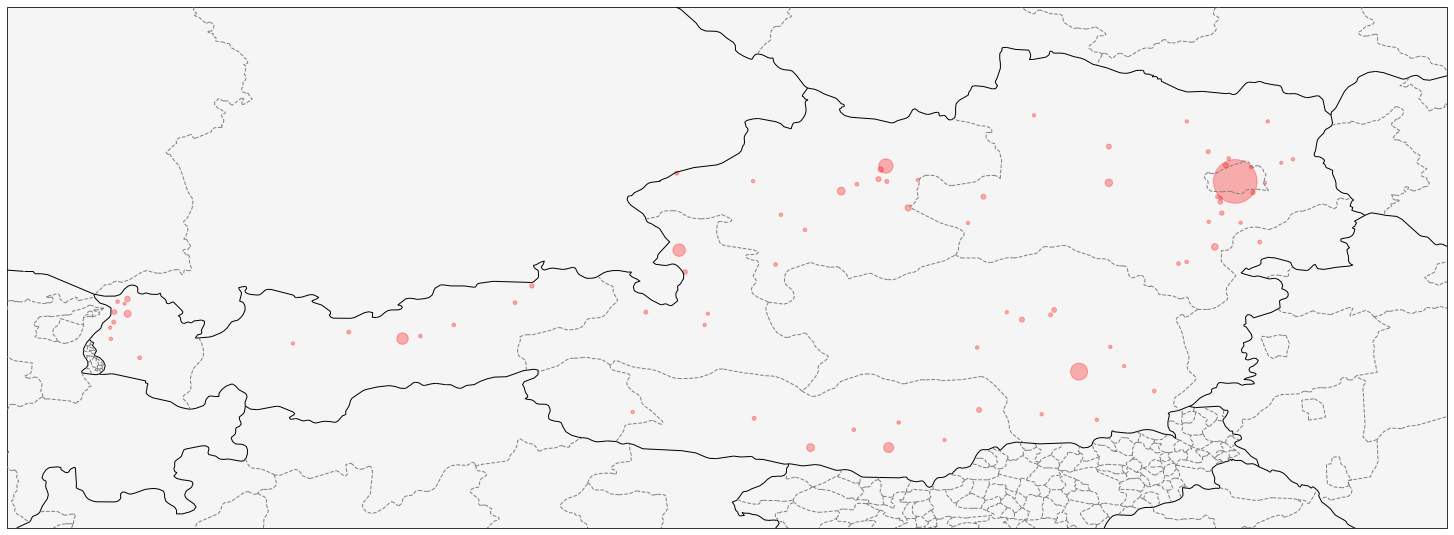

In [111]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
#score[score > 1000] = 1000

ax.add_feature(land_10m, zorder=0, edgecolor='black', facecolor='whitesmoke')
ax.scatter(cpop.lng[pmask], cpop.lat[pmask], transform=ccrs.PlateCarree(), 
           s=pscore, marker='o', alpha=0.3, zorder=2, color='red');
ax.scatter(exts[:2], exts[2:], transform=ccrs.PlateCarree(), facecolor='whitesmoke')

ax.add_feature(cfeature.BORDERS, zorder=19, edgecolor='black', linestyle='-');
ax.add_feature(states_provinces, edgecolor='gray', linestyle='--', zorder=20);

In [112]:
pkde = KernelDensity(**kde_params)
platlonr = cpop.loc[:, ['lat','lng']].values
platlonr = platlonr*np.pi / 180.0
pkde.fit(platlonr[pmask,:], sample_weight=pscore)

pout = np.exp(pkde.score_samples(xy))
pout = pout/np.sum(pout*areas)
Pout = pout*areas*np.sum(pscore)

print(np.max(pout))
len(pout)

dout = pout - rout
Dout = Pout - Rout

886.1197057659757


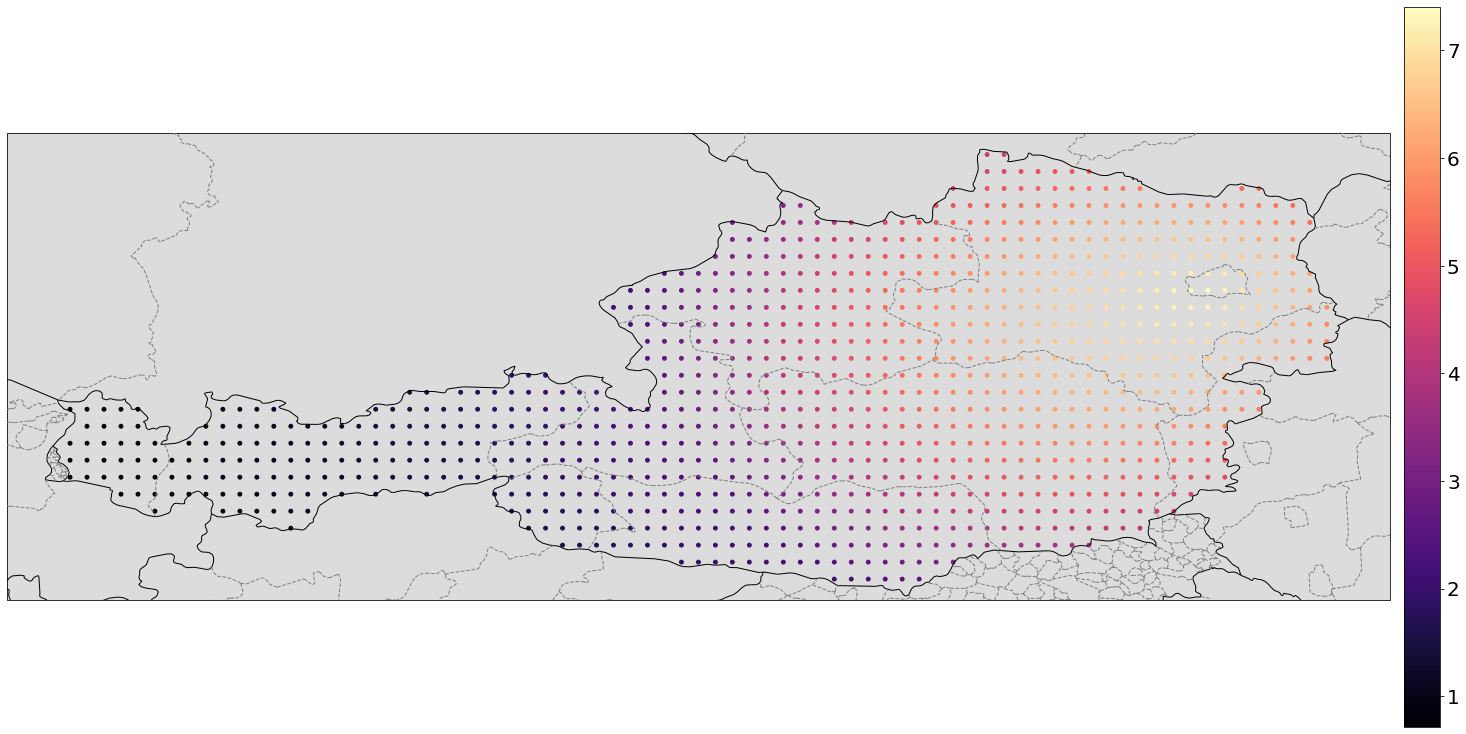

In [113]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.set_facecolor('lightsteelblue')
ax.add_feature(land_10m, zorder=0, edgecolor='black', facecolor='gainsboro')

cs = ax.scatter(xs, ys, transform=ccrs.PlateCarree(), s=15, marker='o', c=Pout, alpha=1, zorder=2, cmap='magma');

ax.add_feature(cfeature.BORDERS, zorder=19, edgecolor='black', linestyle='-');
ax.add_feature(states_provinces, edgecolor='gray', linestyle='--', zorder=20);

cbar = fig.colorbar(cs, fraction=frac, pad=pad, ax=ax)
cbar.ax.tick_params(labelsize=fs);

In [114]:
print(np.sum(pout*areas), np.sum(areas*rout))
print(np.sum(pscore), np.sum(rscore))

0.9999999999999999 0.9999999999999999
4114.0 4114


In [115]:
foo = pd.DataFrame()
foo['Population'] = pout
foo['Research'] = rout
foo['Pop-Res'] = pout - rout

foo['NPopulation'] = Pout
foo['NResearch'] = Rout
foo['NPop-NRes'] = Pout - Rout

foo.describe()

,Population,Research,Pop-Res,NPopulation,NResearch,NPop-NRes
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1.009000e+03
mean,483.942760,484.272472,-0.329712,4.077304,4.077304,2.253456e-16
std,231.906764,269.765423,72.834428,1.933939,2.248018,6.130212e-01
min,83.852122,91.050110,-167.617176,0.715609,0.772246,-1.397948e+00
25%,259.857082,212.919951,-52.087887,2.212115,1.809907,-4.436636e-01
50%,512.339629,454.030064,10.628890,4.340599,3.829971,9.019693e-02
75%,689.508837,715.256177,67.497423,5.786097,6.021429,5.667186e-01
max,886.119706,1047.869301,102.261026,7.404803,8.756453,8.819548e-01


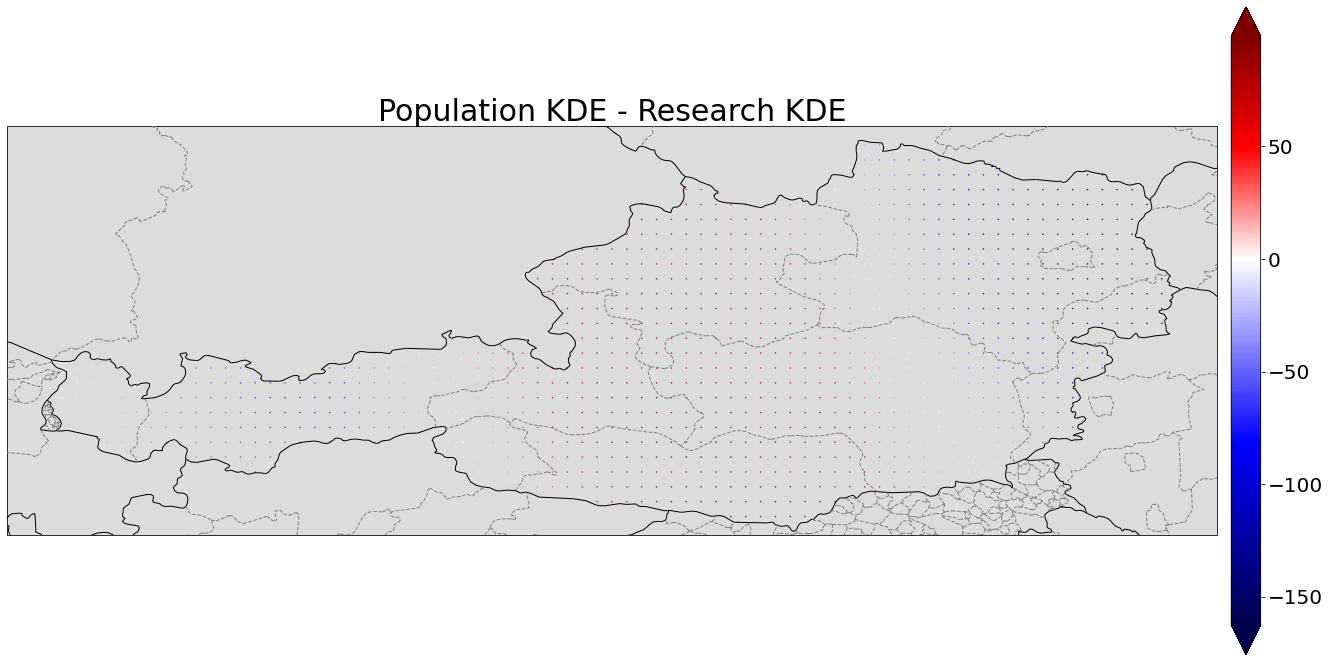

In [116]:
divnorm=colors.TwoSlopeNorm(vmin=np.quantile(dout,0.01), vcenter=0., vmax=np.quantile(dout,0.99))

fig = plt.figure(figsize=(20, 9))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.set_facecolor('lightsteelblue')
ax.add_feature(land_10m, zorder=0, edgecolor='black', facecolor='gainsboro')

cs = ax.scatter(xs, ys, transform=ccrs.PlateCarree(), s=1, marker='.', 
                c=dout, alpha=1, zorder=2, cmap='seismic', norm=divnorm);

ax.add_feature(cfeature.BORDERS, zorder=19, edgecolor='black', linestyle='-');
ax.add_feature(states_provinces, edgecolor='gray', linestyle='--', zorder=20);
cbar = fig.colorbar(cs, pad=0.01, extend='both')
cbar.ax.tick_params(labelsize=20);

ax.set_title('Population KDE - Research KDE', fontsize=fs+10);

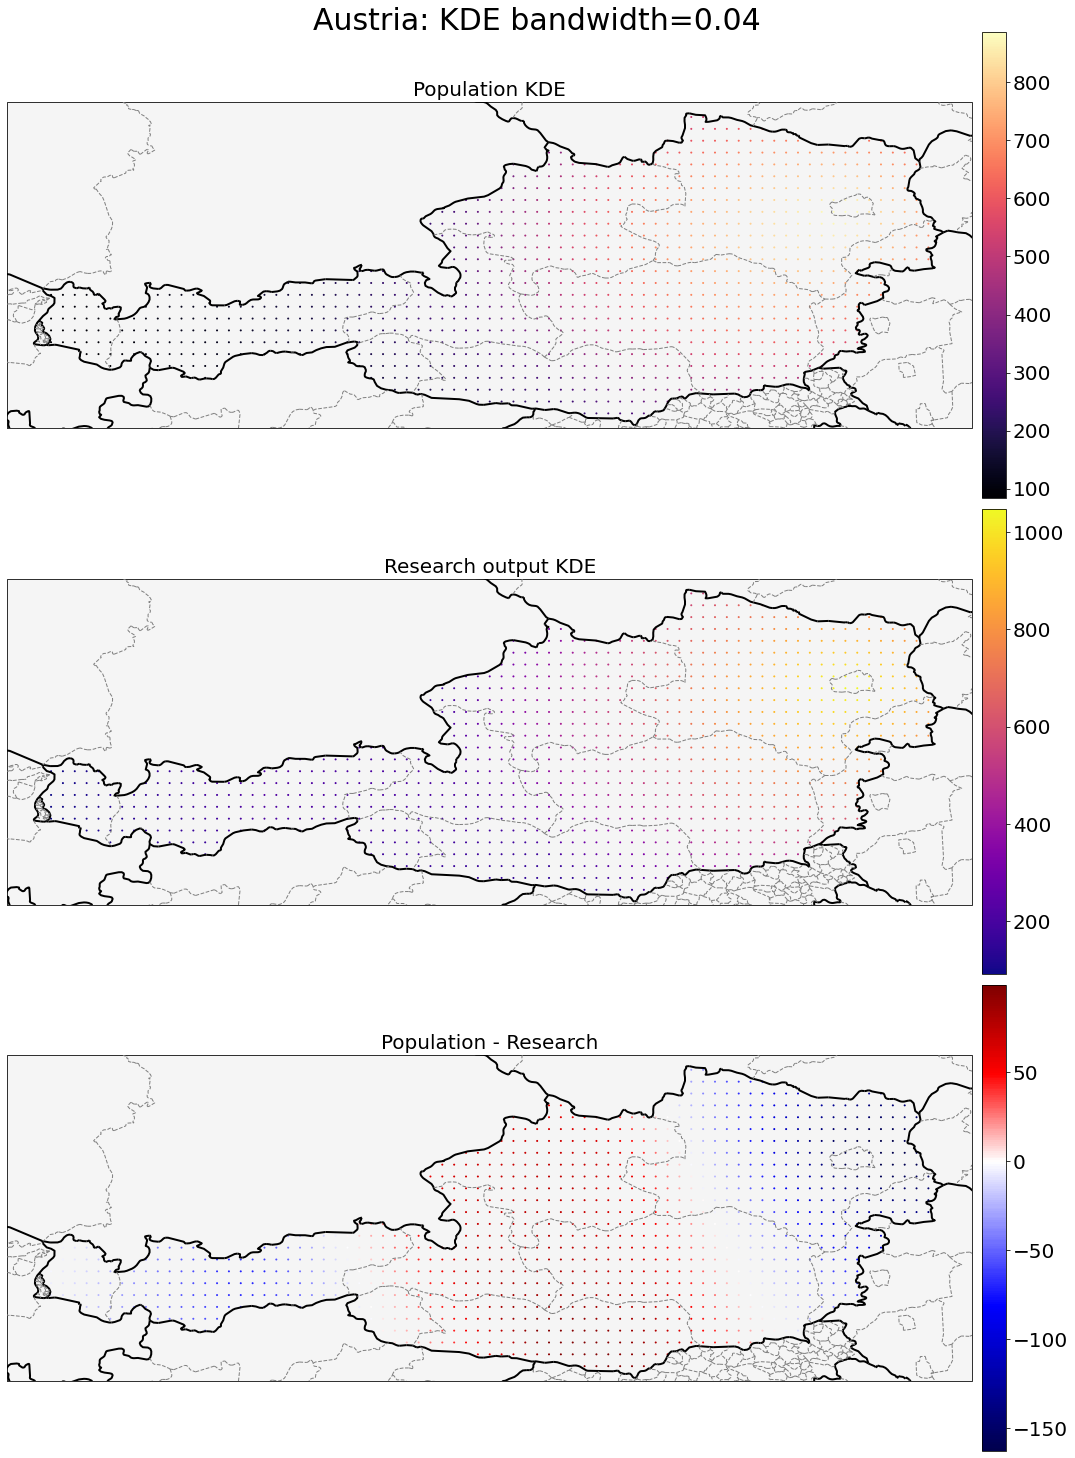

In [117]:
fs, pad, frac, s = 20, 0.01, 0.03, 1
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(15,20), sharex=True, sharey=True)
axs=axs.flatten()
i = 0
cs = axs[i].scatter(xs, ys, transform=ccrs.PlateCarree(), s=s, marker='o', c=pout, alpha=1, zorder=2, cmap='magma');
cbar = fig.colorbar(cs, fraction=frac, pad=pad, ax=axs[i])
cbar.ax.tick_params(labelsize=fs);

i += 1
cs = axs[i].scatter(xs, ys, transform=ccrs.PlateCarree(), s=s, marker='o', c=rout, alpha=1, zorder=2, cmap='plasma');
cbar = fig.colorbar(cs, fraction=frac, pad=pad, ax=axs[i])
cbar.ax.tick_params(labelsize=fs);

i += 1
cs = axs[i].scatter(xs, ys, transform=ccrs.PlateCarree(), s=s, marker='o', c=dout, 
                    alpha=1, zorder=2, cmap='seismic', norm=divnorm);
cbar = fig.colorbar(cs, fraction=frac, pad=pad, ax=axs[i])
cbar.ax.tick_params(labelsize=fs);

for i in range(len(axs)):
    axs[i].set_facecolor('lightsteelblue')
    axs[i].add_feature(land_10m, zorder=0, edgecolor='black', facecolor='whitesmoke')
    axs[i].add_feature(states_provinces, edgecolor='gray', linestyle='--', zorder=20);
    axs[i].add_feature(cfeature.BORDERS, zorder=19, edgecolor='black', linestyle='-', lw=2);
    
axs[1].set_title('Research output KDE', fontsize=fs)
axs[0].set_title('Population KDE', fontsize=fs)
axs[2].set_title('Population - Research', fontsize=fs)

fig.tight_layout();
title = countries[kdx] + ': KDE bandwidth={}'.format(bw)
fig.suptitle(title, y=1.01, fontsize=10+fs);

filename = dst + 'comparison_v_kde_' + countries[kdx].lower() + '_bw{}'.format(bw)
plt.savefig(filename + '.jpg', dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

# Joint plot

In [125]:
hundred = 1e3
Rscore = hundred*rscore/np.sum(rscore)
Pscore = hundred*pscore/np.sum(pscore)

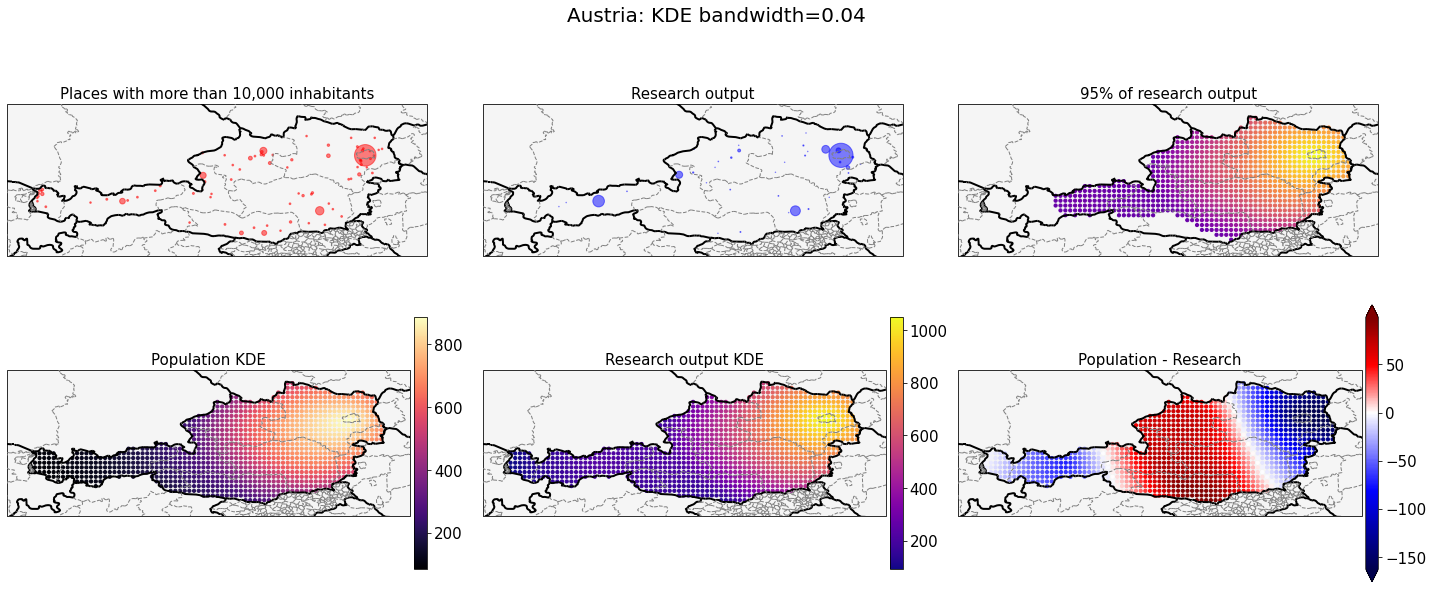

In [126]:
fs = 15
ms = 10
fig, axs = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20,8), sharex=True, sharey=True)
axs=axs.flatten()

axs[0].scatter(cpop.lng[pmask], cpop.lat[pmask], transform=ccrs.PlateCarree(), 
           s=Pscore, marker='o', alpha=0.5, zorder=2, color='red');

axs[1].scatter(rlatlon[rmask, 1], rlatlon[rmask, 0], transform=ccrs.PlateCarree(), 
           s=Rscore, marker='o', alpha=0.5, zorder=2, color='blue');

axs[2].scatter(xs[smask], ys[smask], transform=ccrs.PlateCarree(), vmin=0,
                s=ms, marker='o', c=rout[smask], alpha=1, zorder=2, cmap='plasma');

i = 3
cs = axs[i].scatter(xs, ys, transform=ccrs.PlateCarree(), s=ms, marker='o', 
                    c=pout, alpha=1, zorder=2, cmap='magma');
cbar = fig.colorbar(cs, fraction=frac, pad=pad, ax=axs[i])
cbar.ax.tick_params(labelsize=fs);

i += 1
cs = axs[i].scatter(xs, ys, transform=ccrs.PlateCarree(), s=ms, marker='o', 
                    c=rout, alpha=1, zorder=2, cmap='plasma');
cbar = fig.colorbar(cs, fraction=frac, pad=pad, ax=axs[i])
cbar.ax.tick_params(labelsize=fs);

i += 1
cs = axs[i].scatter(xs, ys, transform=ccrs.PlateCarree(), s=ms, marker='o', c=dout, 
                    alpha=1, zorder=2, cmap='seismic', norm=divnorm);
cbar = fig.colorbar(cs, fraction=frac, pad=pad, ax=axs[i], extend='both')
cbar.ax.tick_params(labelsize=fs);

for i in range(len(axs)):
    axs[i].scatter(exts[:2], exts[2:], transform=ccrs.PlateCarree(), facecolor='whitesmoke', alpha=0)
    axs[i].set_facecolor('lightsteelblue')
    axs[i].add_feature(land_10m, zorder=0, edgecolor='black', facecolor='whitesmoke')
    axs[i].add_feature(states_provinces, edgecolor='gray', linestyle='--', zorder=20);
    axs[i].add_feature(cfeature.BORDERS, zorder=19, edgecolor='black', linestyle='-', lw=2);
    
axs[0].set_title('Places with more than 10,000 inhabitants', fontsize=fs)
axs[1].set_title('Research output', fontsize=fs)
axs[2].set_title('95% of research output', fontsize=fs)
axs[3].set_title('Population KDE', fontsize=fs)
axs[4].set_title('Research output KDE', fontsize=fs)
axs[5].set_title('Population - Research', fontsize=fs)

fig.tight_layout();
title = countries[kdx] + ': KDE bandwidth={}'.format(bw)
fig.suptitle(title, y=1.03, fontsize=5+fs);

filename = dst + 'distribution_comparison_h_' + countries[kdx].lower() + '_bw{}'.format(bw)
plt.savefig(filename + '.jpg', dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})

# Significant density differences

In [120]:
wald = np.zeros(len(rout))
foo = np.nonzero(Dout)[0]
wald[foo] = (len(rout)*bw*Dout[foo]**2)/(Rout+Pout)[foo]

In [121]:
len(Dout[np.abs(Dout) < 1])

915

In [122]:
pd.Series(wald).describe()

count    1009.000000
mean        1.979330
std         1.757127
min         0.000003
25%         0.446780
50%         1.603409
75%         3.016946
max         9.733846
dtype: float64

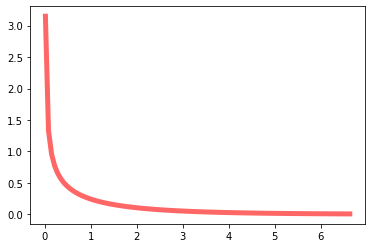

In [123]:
from scipy.stats import chi2
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

dof = 1
mean, var, skew, kurt = chi2.stats(dof, moments='mvsk')
x = np.linspace(chi2.ppf(0.1, dof),chi2.ppf(0.99, dof), 100)
ax.plot(x, chi2.pdf(x, dof),'r-', lw=5, alpha=0.6, label='chi2 pdf');

In [124]:
pval = 1 - chi2.cdf(wald, df)
len(pval[pval > 0.05])

TypeError: '>' not supported between instances of 'str' and 'int'